In [745]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from scipy.stats import loguniform, beta, uniform

import matplotlib.pyplot as plt
import warnings

sns.set_palette('pastel')
warnings.filterwarnings('ignore')

### 1. Raw dataset

This project aims to solve the task of predicting car prices. The dataset [Ultimate Car Price Prediction Dataset](https://www.kaggle.com/datasets/mohidabdulrehman/ultimate-car-price-prediction-dataset)
 containing over 46,000 records, was chosen for analysis. Below is a description of all the columns.

Columns:
* **Id:** A unique identifier for each car listing.
  
* **Price:** The price range of the cars, with specific price labels and counts.
  
* **Company Name:** The name of the car manufacturing company, with percentages of each company's representation.

* **Model Name:** The model name of the cars, with percentages of each model's representation.

* **Model Year:** The range of car manufacturing years, with counts and percentages.

* **Location:** The location of the cars, specifying the regions where they are available for purchase, along with their percentages.

* **Mileage:** Information on the mileage of the cars, with mileage ranges, counts, and percentages.

* **Engine Type:** Descriptions of the engine types, with percentages for each type.

* **Engine Capacity:** Engine capacity ranges with counts and percentages.

* **Color:** The color distribution of the cars, with percentages for each color.

* **Assembly**: Indicates whether the car is locally assembled or imported, with respective counts and percentages for each category.

* **Body Type**: Describes the type of car body (e.g., Hatchback, Sedan), with the distribution and percentages of each body type.

* **Transmission Type**: Specifies the type of transmission (e.g., Automatic, Manual), along with the counts and percentages for each type.

* **Registration Status**: Provides the registration status of the car (e.g., Registered, Un-Registered), with percentages for each category.

Our main task will be to build a model for predicting car prices, which means that the target variable will be **Price** column

In [746]:
df = pd.read_csv("car_dataset.csv")
df.head()

,Company Name,Model Name,Price,Model Year,Location,Mileage,Engine Type,Engine Capacity,Color,Assembly,Body Type,Transmission Type,Registration Status
0,Suzuki,Mehran,490000,2009,Punjab,48000,Petrol,800,Silver,Local,Hatchback,Manual,Registered
1,Honda,City,1855000,2015,Punjab,61000,Petrol,1300,White,Local,Sedan,Manual,Registered
2,Daihatsu,Mira,1275000,2011,Sindh,76000,Petrol,660,Silver,Imported,Hatchback,Automatic,Registered
3,BMW,7,3000000,2003,Islamabad,230000,Petrol,3600,White,Imported,Sedan,Automatic,Registered
4,Suzuki,Alto,1525000,2019,Punjab,9000,Petrol,660,Silver,Local,Hatchback,Automatic,Registered


The size of the dataset

In [747]:
df.shape # 5000 rows and 13 columns

(5000, 13)

In [748]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Company Name         5000 non-null   object
 1   Model Name           5000 non-null   object
 2   Price                5000 non-null   int64 
 3   Model Year           5000 non-null   int64 
 4   Location             5000 non-null   object
 5   Mileage              5000 non-null   int64 
 6   Engine Type          5000 non-null   object
 7   Engine Capacity      5000 non-null   int64 
 8   Color                5000 non-null   object
 9   Assembly             5000 non-null   object
 10  Body Type            5000 non-null   object
 11  Transmission Type    5000 non-null   object
 12  Registration Status  5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB


### 2. Feature Engineering and Feature Analyzing

#### 2.1 Missing values

First of all, let's check for the null values

In [749]:
df.isnull().sum(axis=0) / df.shape[0]

Company Name           0.0
Model Name             0.0
Price                  0.0
Model Year             0.0
Location               0.0
Mileage                0.0
Engine Type            0.0
Engine Capacity        0.0
Color                  0.0
Assembly               0.0
Body Type              0.0
Transmission Type      0.0
Registration Status    0.0
dtype: float64

Since there are zero null records we will generate some missing NaN values randomly

In [750]:
missing_ratios = {
    'Model Year': 0.1,       # 10% for Model Year
    'Mileage': 0.05,         # 5% for Mileage
    'Color': 0.07,           # 7% for Color
    'Engine Capacity': 0.03, # 3% for Engine Capacity
    'Body Type': 0.07        # 7% for body type
}

for column, ratio in missing_ratios.items():
    num_missing = int(len(df) * ratio)
    missing_indices = np.random.choice(df.index, num_missing, replace=False)
    df.loc[missing_indices, column] = np.nan

In [751]:
df.isnull().sum(axis=0) / df.shape[0]

Company Name           0.00
Model Name             0.00
Price                  0.00
Model Year             0.10
Location               0.00
Mileage                0.05
Engine Type            0.00
Engine Capacity        0.03
Color                  0.07
Assembly               0.00
Body Type              0.07
Transmission Type      0.00
Registration Status    0.00
dtype: float64

Let's plot the missing values

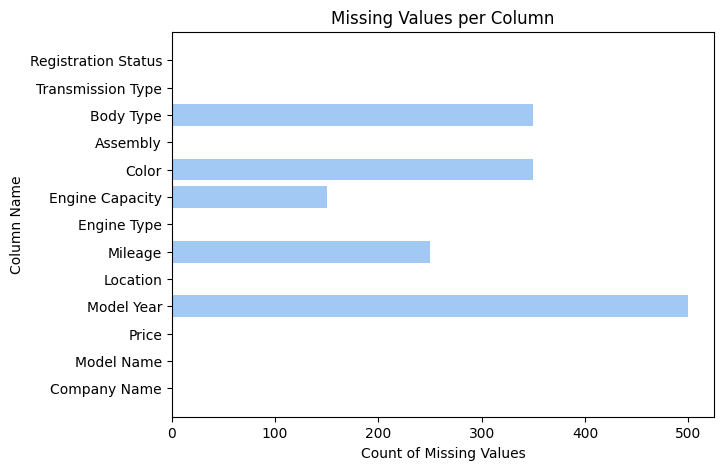

In [752]:
data = df.isna().sum()
plt.figure(figsize=(7, 5))
plt.barh(data.index, data.values)
plt.title("Missing Values per Column")
plt.xlabel("Count of Missing Values")
plt.ylabel("Column Name")
plt.show()

We can use the following strategies to handle missing values:
* Remove rows or columns with missing values if their proportion is too high or if they are not critical for analysis
* Imputation (Filling Missing Values)
  * Use the mean(), median(), or anything other for numerical columns
  * Use the mode(), -1, 0 or "other" for categorical columns
  * KNNImputer (more advanced, uses ML algorithms)

We will do it in the following step **3.1**

#### 2.2 Plots and graph analyzing

##### 2.2.1 Numerical features

In [753]:
num_features = ['Mileage', 'Engine Capacity', 'Model Year', 'Price']

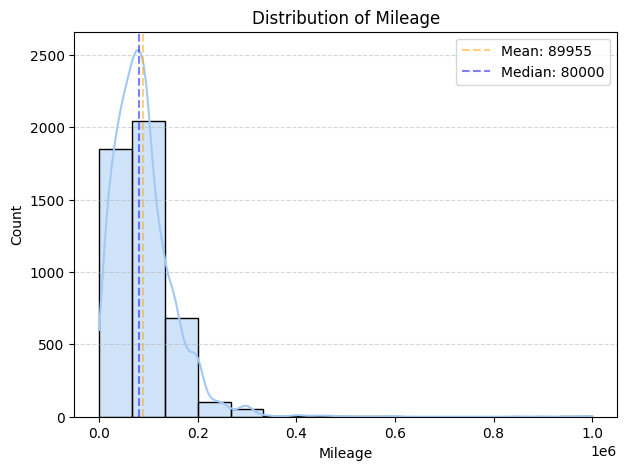

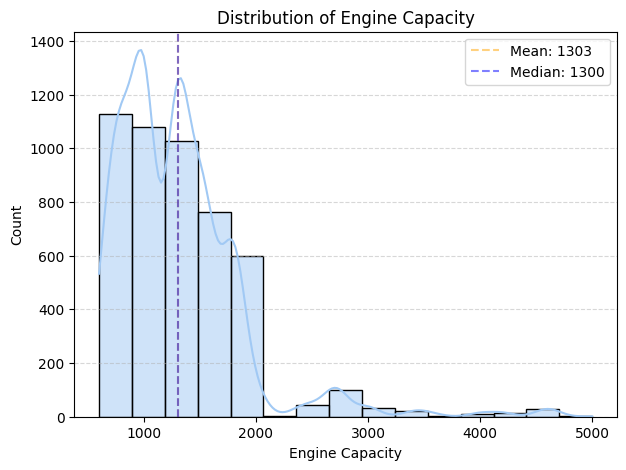

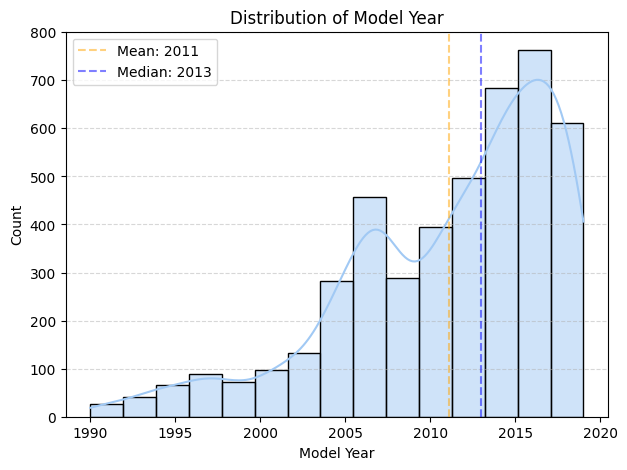

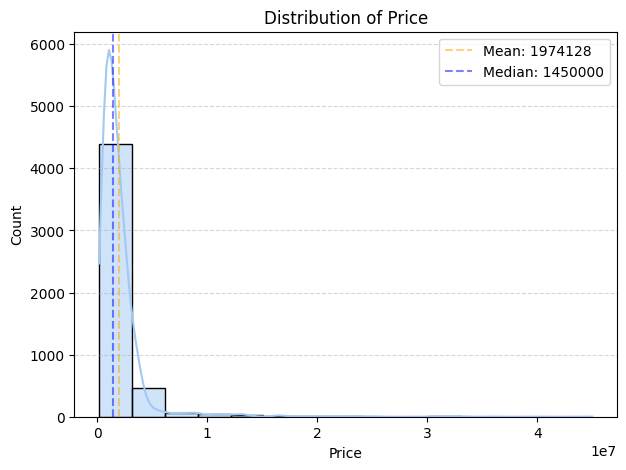

In [754]:
for col in num_features:
    plt.figure(figsize=(7, 5))
    sns.histplot(df[col], kde=True, bins=15)
    plt.title(f'Distribution of {col}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    mean_value = df[col].mean()
    median_value = df[col].median()
    plt.axvline(mean_value, color='orange', linestyle='--', label=f'Mean: {mean_value:.0f}', alpha=0.5)
    plt.axvline(median_value, color='blue', linestyle='--', label=f'Median: {median_value:.0f}', alpha=0.5)
    plt.legend()
    plt.show()

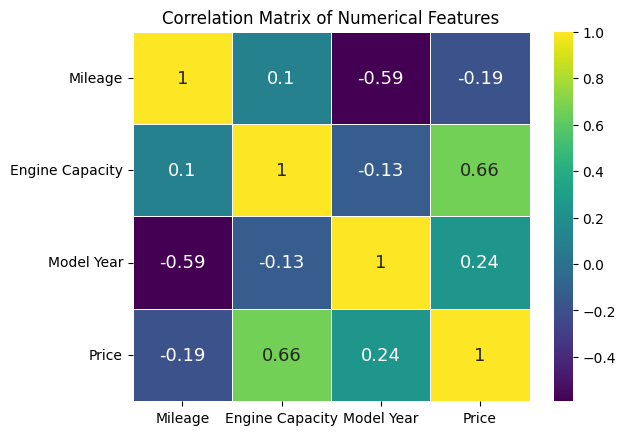

In [755]:
corr_matrix = df[num_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="viridis", linewidths=0.5, annot_kws={"size": 13})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

##### 2.2.2 Categorical Features

In [756]:
categorical_features = ['Assembly', 'Body Type', 'Transmission Type', 'Registration Status', 
                        'Color', 'Engine Type', 'Location', 'Company Name', 'Model Name']

The function <code>preprocess_categories</code> is designed to preprocess certain categorical features that have a large number of unique categories, each accounting for less than 4% of the dataset. This ensures that pie charts generated from these features remain readable. All discarded categories will be grouped under the category "Other."

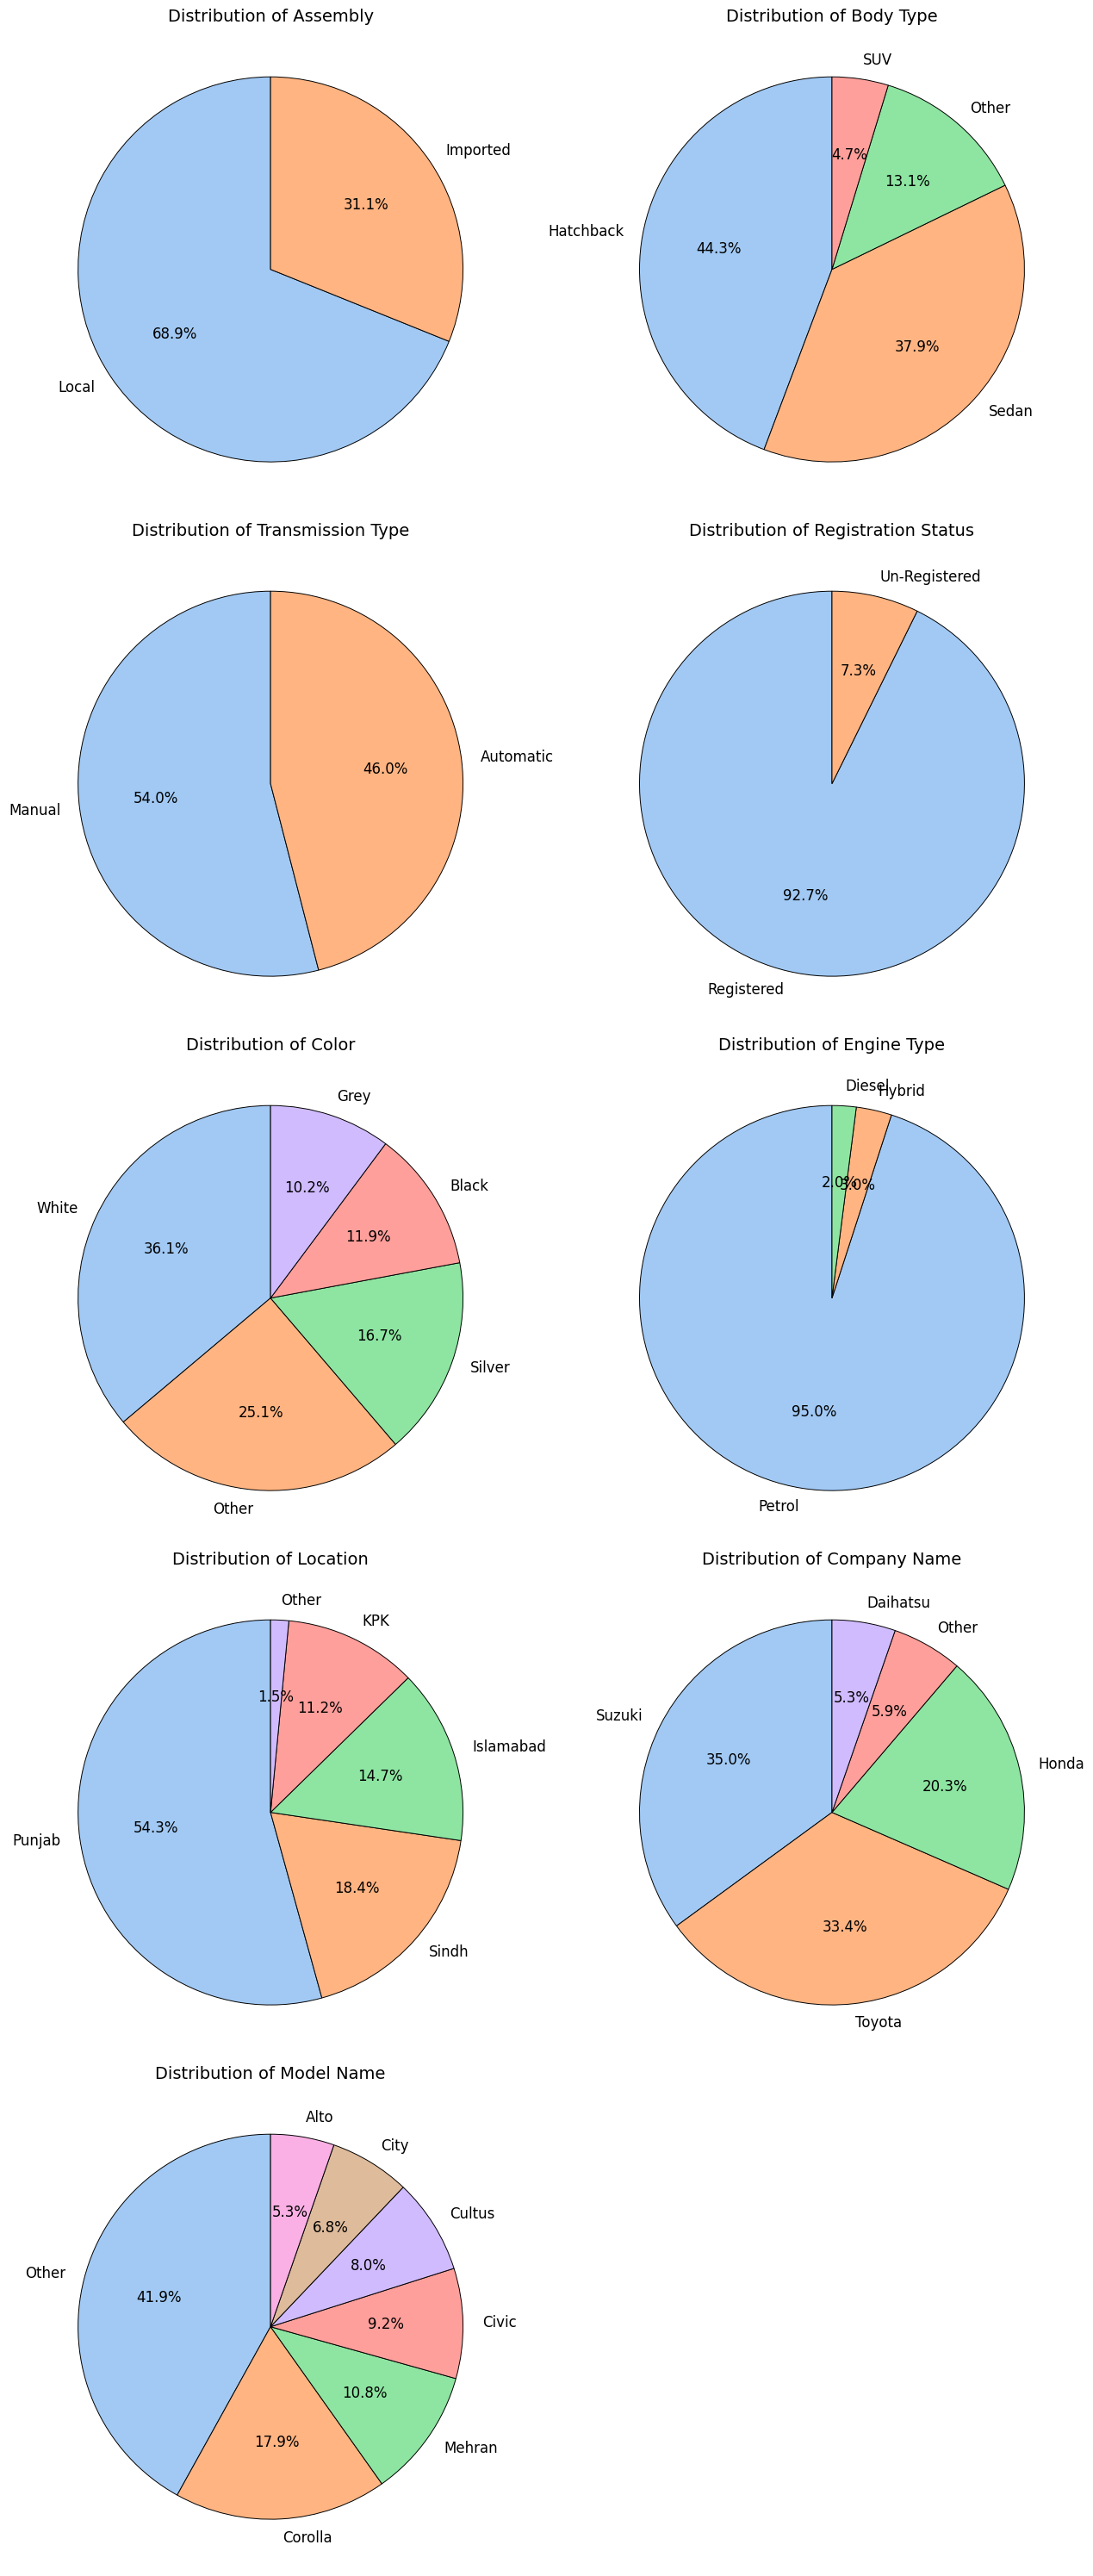

In [757]:
import matplotlib.pyplot as plt

def preprocess_categories(data, column, threshold=0.04):
    data = data.copy()
    total_count = len(data)
    value_counts = data[column].value_counts()
    valid_categories = value_counts.index
    
    if data[column].nunique() > 5:
        valid_categories = value_counts[value_counts / total_count >= threshold].index
    
    data[column] = data[column].apply(lambda x: x if x in valid_categories else 'Other')
    return data

n_cols = 2
n_rows = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 30))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    processed_df = preprocess_categories(df, col)
    
    processed_df[col].value_counts().plot.pie(
        autopct='%1.1f%%', 
        startangle=90, 
        wedgeprops={'linewidth': 0.7, 'edgecolor': 'black'},
        textprops={'fontsize': 12},
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_ylabel('')

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


### 3. Data Transformation Pipeline

#### 3.1 Pipelines and Transformers

Now we need to define the data transformation pipelines.

**Choice of Scalers for numerical features:**

* **Mileage:** The distribution is asymmetric with a long right tail, and the mean is greater than the median, which confirms the presence of outliers. Therefore, we will use the <code>MinMaxScaler</code> in this case.

* **Engine Capacity:** The distribution is asymmetric with outliers on the right. The mean and median are close, but the tail on the right indicates the presence of rare large values. Therefore, we will use the <code>MinMaxScaler</code> in this case.

* **Model Year:** The distribution is closer to exponential with a slight dip in the middle and well-defined boundaries (year of manufacture). The mean and median are close, and there are almost no outliers. Therefore, we will use the <code>StandardScaler</code> in this case.

Also, we should not forget to handle missing values in numerical columns: <code>Model Year</code>, <code>Mileage</code>, <code>Engine Capacity</code>. For such a purpose we will use ML algorithm <code>KNN Imputer</code>.

**Choice of Scalers for numerical features:**

For all categorical features we will use <code>OneHotEncoder</code> to encode categorical features into numbers. Also, we should not forget to fill missing values in categorical columns: <code>Color</code>, <code>Body Type</code>. For such a purpose we will use <code>SimpleImputer</code>.

In [758]:
pipeline_mileage_engine = Pipeline([
    ('imp_mileage_engine', KNNImputer(n_neighbors=5)),
    ('min_max_scaler', MinMaxScaler())
])

pipeline_model_year = Pipeline([
    ('imp_price', KNNImputer(n_neighbors=5)),
    ('std_scaler', StandardScaler())
])

pipeline_color_body = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'))
])

pipeline_categorical = Pipeline([
    ('one_hot', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'))
])

final_transformation = ColumnTransformer(transformers=[
    ('mileage_engine', pipeline_mileage_engine, ['Mileage', 'Engine Capacity']),
    ('color_body', pipeline_color_body, ['Color', 'Body Type']),
    ('model_year', pipeline_model_year, ['Model Year']),
    ('categorical', pipeline_categorical, ['Assembly', 'Transmission Type', 'Registration Status',
                                           'Engine Type', 'Location', 'Company Name', 'Model Name'])
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

#### 3.2 Train and Test sets

In [759]:
X = df.drop(columns=['Price'])
y = df['Price']

In [760]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [761]:
X_train.shape[0], X_test.shape[0] # sizes of the train and test sets

(4000, 1000)

### 4. Model Selection

At this stage, we assume that our data has been properly preprocessed and transformed. The next step involves defining candidate models and selecting the best ones using a nested cross-validation process, which integrates hyperparameter optimization and model selection into a unified workflow.

In [762]:
X_train = final_transformation.fit_transform(X_train)
X_test = final_transformation.transform(X_test)

In [763]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    }
]

In [765]:
regressor_configs = [
    {
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True],
    },
    {
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [5, 7],
        'regressor__weights': ['distance'],
        'regressor__algorithm': ['auto']
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [10, 15, 20],
        'regressor__max_depth': [10, 15],
        'regressor__min_samples_split': [10, 15],
        'regressor__min_samples_leaf': [5, 10]
    },
    {
        'regressor': [GradientBoostingRegressor()],
        'regressor__n_estimators': [10, 15, 20],
        'regressor__learning_rate': loguniform(0.01, 0.03),
        'regressor__max_depth': [3, 4],
        'regressor__min_samples_split': [15, 20],
        'regressor__min_samples_leaf': [10, 20],
        'regressor__subsample': [0.6, 0.8],
        'regressor__max_features': ['sqrt', 'log2'],
        'regressor__ccp_alpha': [0.01, 0.05, 0.1]
    }
]


In [782]:
all_configs = []
for configuration in itertools.product(dim_reduction_configs, regressor_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters))

In [767]:
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduction', PCA()),
    ('regressor', RandomForestRegressor())
])

In [768]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='r2'
)

In [769]:
scores = cross_validate(rs, X_train, y_train, scoring='r2', cv=5, return_estimator=True, verbose=3)

[CV] END ......................................., score=0.798 total time=   0.4s
[CV] END ......................................., score=0.711 total time=   0.6s
[CV] END ......................................., score=0.874 total time=   0.5s
[CV] END ......................................., score=0.873 total time=   0.4s
[CV] END ......................................., score=0.845 total time=   0.4s


Now, we can print the best parameters of each estimator for each validation fold

In [770]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['regressor'],
          estimator.best_estimator_.get_params()['regressor'].get_params())
    print(scores['test_score'][index])
    print('--' * 70)

None
KNeighborsRegressor(weights='distance') {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.7982285637236849
--------------------------------------------------------------------------------------------------------------------------------------------
None
RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=15,
                      n_estimators=20) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7111426683296012
----------------------------------------------------------------------------------------------------------

In [771]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print(f'R2 on training set:{r2_train}, R2 on test set:{r2_test}')

R2 on training set:0.9999428281442173, R2 on test set:0.776119166073315
R2 on training set:0.851579966700099, R2 on test set:0.8942828668569167
R2 on training set:0.8896296448838368, R2 on test set:0.9052905725556737
R2 on training set:0.8764793985794388, R2 on test set:0.9017159957739256
R2 on training set:0.8868835253486895, R2 on test set:0.9071075293010273


As we can see, the <code>KNeighborsRegressor</code> is significantly overfitting, while the <code>RandomForestRegressor</code> shows nearly identical R² scores on the training and test sets. Therefore, we will use it as the best model for further refinement.

#### 4.1 Refinement of the selected model

In [772]:
best_pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])

In [773]:
param_distributions = {
        'regressor__n_estimators': range(10, 20),
        'regressor__max_depth': [10, 15],
        'regressor__min_samples_split': [10, 15],
        'regressor__min_samples_leaf': [5, 10]
    }

In [774]:
best_estimator = RandomizedSearchCV(
    estimator = best_pipeline,
    param_distributions = param_distributions,
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42),
    n_iter=10,
    scoring='r2'
)

In [775]:
best_estimator.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('regressor',
                                              RandomForestRegressor())]),
                   param_distributions={'regressor__max_depth': [10, 15],
                                        'regressor__min_samples_leaf': [5, 10],
                                        'regressor__min_samples_split': [10,
                                                                         15],
                                        'regressor__n_estimators': range(10, 20)},
                   scoring='r2')

In [776]:
best_estimator.best_estimator_

Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=5,
                                       min_samples_split=10,
                                       n_estimators=10))])

In [777]:
print(f"R2 on test: {r2_score(y_test, best_estimator.best_estimator_.predict(X_test))}")
print(f"R2 on train: {r2_score(y_train, best_estimator.best_estimator_.predict(X_train))}")
print(f"MAE on test: {mean_absolute_error(y_test, best_estimator.best_estimator_.predict(X_test))}")
print(f"MAE on train: {mean_absolute_error(y_train, best_estimator.best_estimator_.predict(X_train))}")

R2 on test: 0.9018677862041288
R2 on train: 0.8986552005203065
MAE on test: 292116.7114251653
MAE on train: 230309.1092686355


In [778]:
cls = best_estimator.best_estimator_

In [779]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'r2',
                                                       shuffle = False)

(0.6, 1.03)

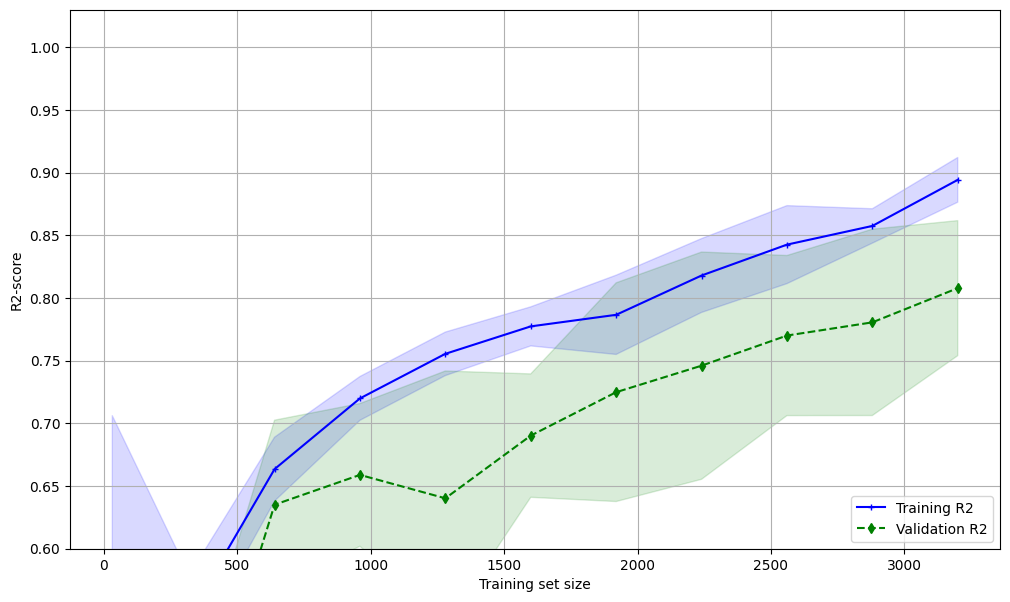

In [780]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training R2')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation R2')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('R2-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])